In [1]:
import pandas as pd
import re

In [4]:
df = pd.read_csv('../yamagishi_kaneko_NLS_table.csv')

In [3]:
# Keep only the second column
# Note: Python uses 0-based indexing, so the second column is indexed as 1
df_reduced = df.iloc[4:, [1]]

df_reduced_reset = df_reduced.reset_index(drop=True)

df_reduced_reset.columns = ['UniProt_ID']




In [4]:
uniprot_ids  = df_reduced_reset['UniProt_ID'].tolist()

In [6]:
# Example list of UniProt IDs
uniprot_ids[:5]

['Q14738', 'Q13362', 'Q9NRA8', 'P42684', 'Q4JIM5']

In [5]:
# Check if there are duplicates
def has_duplicates(lst):
    return len(lst) != len(set(lst))

# Check if the list has duplicates
def check_duplicates(lst):
    if has_duplicates(lst):
        print("There are duplicates.")
    else:
        print("No duplicates found.")

In [6]:
check_duplicates(uniprot_ids)

There are duplicates.


In [7]:
# Remove duplicates while preserving order
seen = set()
uniprot_ids_no_duplicate = []
for item in uniprot_ids:
    if item not in seen:
        seen.add(item)
        uniprot_ids_no_duplicate.append(item)

In [8]:
check_duplicates(uniprot_ids_no_duplicate)

No duplicates found.


In [9]:
print(len(uniprot_ids_no_duplicate))
print(len(uniprot_ids))

1186
1364


In [13]:
# Save the modified DataFrame to a new CSV file
with open('UniProt_ID.txt', 'w+') as f:
    for id in uniprot_ids_no_duplicate:
        print(id, file = f)

In [95]:
import requests
from requests.adapters import HTTPAdapter, Retry

re_next_link = re.compile(r'<(.+)>; rel="next"')
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

def get_next_link(headers):
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)

def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()
        total = response.headers["x-total-results"]
        yield response, total
        batch_url = get_next_link(response.headers)

In [4]:


url = 'https://rest.uniprot.org/idmapping/uniprotkb/results/1b3c0cf5386fbc2de07460b673225119c324c735?format=fasta&size=500'

with open('nuclear_protein_sequences.txt', 'w') as f:
    for batch, total in get_batch(url):
        for line in batch.text.splitlines():
            print(line, file = f)  # Print each sequence to its own line

# with open('Sequence.csv', 'w') as f:
#     for batch, total in get_batch(url):
#         fasta_data = batch.text
#         sequences = re.split(r'^>.*\n?', fasta_data, flags=re.MULTILINE)
#         sequences = [seq for seq in sequences if seq.strip() != '']  # Remove empty entries
#         for seq in sequences:
#             f.write(seq)  # Print each sequence to its own line



In [11]:
url = 'https://rest.uniprot.org/idmapping/uniprotkb/results/1b3c0cf5386fbc2de07460b673225119c324c735?fields=accession%2Clength&format=tsv&size=500'

with open('nuclear_protein_lengths.tsv', 'w') as f:
    for batch, total in get_batch(url):
        for line in batch.text.splitlines():
            print(line, file = f)  # Print each sequence to its own line



In [72]:
df = pd.read_csv('./nuclear_protein_lengths.tsv', delimiter='\t')

In [73]:
df.drop('From',axis=1,inplace=True)
df.rename(columns={'Entry':'ID'}, inplace=True)

In [77]:
df = df[~(df['Length'] == 'Length')]

In [78]:
df['Length'].values.any()

'602'

In [79]:
df[df.isnull().any(axis=1)]

,ID,Length


In [80]:
df.iloc[1000]

ID        Q8IX01
Length      1082
Name: 1002, dtype: object

In [81]:
df['Length'] = pd.to_numeric(df['Length'], errors='coerce')
min_length, max_length = df['Length'].min(), df['Length'].max()
print(f'The lengths are from {min_length} to {max_length}')

The lengths are from 80 to 5890


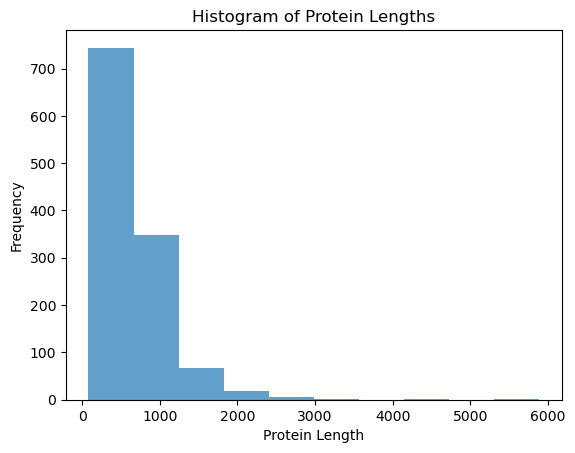

In [6]:
import matplotlib.pyplot as plt


df['Length'].plot(kind='hist', alpha=0.7)
plt.xlabel('Protein Length')
plt.ylabel('Frequency')
plt.title('Histogram of Protein Lengths')
plt.show()

In [12]:
from sklearn.cluster import KMeans

In [82]:
X = df['Length'].values.reshape(-1,1)

kmeans = KMeans(n_clusters=10, random_state=345).fit(X)

df['Cluster'] = kmeans.labels_

print(df)

/Users/mingzhang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


          ID  Length  Cluster
0     Q14738     602        6
1     Q13362     524        5
2     Q9NRA8     985        8
3     P42684    1182        4
4     Q4JIM5    1182        4
...      ...     ...      ...
1184  Q5SXI5     585        6
1185  Q96CK0     615        6
1186  Q24JY4     154        7
1187  O43257     154        7
1188  Q8R331     154        7

[1187 rows x 3 columns]


In [2]:
df[df['Cluster']==7]['Length']

NameError: name 'df' is not defined

In [91]:
import os


subfolder = 'nuclear_proteins_ids'

if not os.path.exists(subfolder):
    os.makedirs(subfolder)
    
    
for i in range(10):
    file_path = os.path.join(subfolder, f'nuclear_protein_ids_{i}.txt')
    with open(file_path, 'w') as f:
        ids = df[df['Cluster']==i]['ID']

        for id in ids:
            print(id, file=f)

In [96]:
url_0 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/ba823190bd392a76c8fc654524603a7559e71bba?format=fasta&size=500'
url_1 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/daf8bdaffdb7494131ded004ab52093974537f0b?format=fasta&size=500'
url_2 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/e0f2b7b9399e3d5e1d2324960c15bb9c45e575c2?format=fasta&size=500'
url_3 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/0cfc22d1f9c4ec827e96d117549b2128f938ac99?format=fasta&size=500'
url_4 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/7e8effb2ba387d9c4d92391d562027fac91e780b?format=fasta&size=500'
url_5 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/78ff81ebfe203f4bf82f22a48e26c82968e5e4de?format=fasta&size=500'
url_6 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/93553c412b6a1e925a673159e1ad10fd3b87b8db?format=fasta&size=500'
url_7 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/d5969819d88593187f87ee3c410df0fad55d0bea?format=fasta&size=500'
url_8 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/6297249f1561da0c81f0c3c74f3f3e217671aef2?format=fasta&size=500'
url_9 = 'https://rest.uniprot.org/idmapping/uniprotkb/results/051aea3e8cd206d5cd0de0ba649b47aaa246b347?format=fasta&size=500'

url_list = [url_0, url_1, url_2, url_3, url_4, url_5, url_6, url_7, url_8, url_9]

subfolder = 'nuclear_proteins_sequences'

if not os.path.exists(subfolder):
    os.makedirs(subfolder)
    
    
for i in range(10):
    file_path = os.path.join(subfolder, f'nuclear_protein_sequences_{i}.txt')

    with open(file_path, 'w') as f:
        for batch, total in get_batch(url_list[i]):
            for line in batch.text.splitlines():
                print(line, file = f)  # Print each sequence to its own line



# Testing

In [46]:
df['Length'].values.any()

'602'

In [56]:
df[df.isnull().any(axis=1)]

,ID,Length
500,Entry,NaN
1001,Entry,NaN


In [48]:
df.iloc[602]

ID        P25799
Length       971
Name: 602, dtype: object

In [24]:
df[df['Length']<100]

,ID,Length
546,Q32KU9,82.0
547,Q8IVN3,82.0
548,Q99JI1,82.0
549,Q80XX4,82.0
650,O60356,82.0
651,O54842,80.0
652,Q9WTK0,80.0
988,Q9NS26,97.0
990,Q9NY87,97.0
991,Q9BXN6,97.0
